In [1]:
import numpy as np 
np.random.seed(7)
import math
import sys
# print(sys.path)
# print(sys.executable)
# print(sys.executable.split('/')[-3])
from scipy.stats import norm,laplace
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter, OrderedDict
import copy 
import pandas as pd
import time
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM

from tslearn.clustering import TimeSeriesKMeans


In [2]:
Dataset = r'../15minute_data_newyork/15minute_data_newyork.csv'
fulldata = pd.read_csv(Dataset) 

# Data Preprocessing

In [3]:
Dataset = r'../15minute_data_newyork/15minute_data_newyork.csv'
fulldata = pd.read_csv(Dataset) 
data=fulldata[['dataid','local_15min','grid']]
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])
ids=sorteddata['dataid'].unique().tolist()
housing_data = []
housing_data_numpy = []
def convertDate(d):
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    # housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for faster ploting 
    # housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)


In [4]:
def create_dataset(dataset, look_back=1, look_ahead=None):
	"function for creating dataset for model, X being the known data, and Y being target data"
	if look_ahead is None:
		look_ahead = look_back
	dataX, dataY = [], []
	for i in range(len(dataset)-2*look_back):
		dataX.append(dataset[i:(i+look_back), 0])
		if look_ahead == 0:
			dataY.append(dataset[i + look_back, 0])
		else:
			dataY.append(dataset[(i+look_back):(i+look_back+look_ahead), 0])
		
	return np.array(dataX), np.array(dataY)

def get_avg_day(look_back =96,  house = 0, absolute = False):

    dataframe = housing_data[house]['grid']
    fulldays=len(dataframe)//look_back
    grid_data=dataframe.to_numpy()

    grid_day_matrix=grid_data[:(look_back*fulldays)].reshape(-1, look_back)
    if absolute == True:
        grid_day_matrix = abs(grid_day_matrix)
    #avg house0 grid data 
    avg_house_grid=np.mean(grid_day_matrix, axis=0)
    # print(grid_day_matrix.shape)
    return avg_house_grid

model = load_model('../models/LSTM_nonsolar/LSTM_house_model_0_75_adam.h5') #change here nonsolar model

scaler = MinMaxScaler(feature_range=(0, 1))

def get_avg_day_pred(look_back =96,  house = 0, scaler = scaler, model = model):

    dataframe = housing_data[house]['grid']
    dataset = np.matrix(dataframe.values).transpose()
    dataset = dataset.astype('float32')
    dataset = scaler.fit_transform(dataset)

    house0X, house0Y = create_dataset(dataset, look_back)
    house0X = house0X.reshape(house0X.shape[0], house0X.shape[1],1)
    house0Predict = model.predict(house0X)
    house0Predict = scaler.inverse_transform(house0Predict)
    house0Y = scaler.inverse_transform(house0Y)
    train0Score = math.sqrt(mean_squared_error(house0Y, house0Predict))

    pred_house0_matrix=house0Predict[::look_back]
    
    #avg house0 grid data 
    pred_house0_grid=np.mean(pred_house0_matrix, axis=0)
    # print(grid_day_matrix.shape)
    return pred_house0_grid, train0Score, house0X, house0Y, house0Predict

# Data Analysis
## Average Day

In [5]:
avg_house_list = []
for i in range(len(housing_data)):
    avg_house_list.append(get_avg_day(house= i))
np_avg_house = np.asarray(avg_house_list) 
r,c =np_avg_house.shape
np_avg_house_3d = np.reshape(np_avg_house,(r,c,1))

In [6]:
KMmodel=TimeSeriesKMeans.from_hdf5('../models/KM/KM1.h5')
houseclasses= KMmodel.fit_predict(np_avg_house_3d)

In [7]:
solar_housing_idxs = np.where(houseclasses==1)[0] #change here to 1
print(solar_housing_idxs.shape)
solar_housing_idxs

(13,)


array([ 3,  7,  8,  9, 10, 11, 13, 15, 16, 17, 18, 22, 24])

In [8]:
solar_avg_house_list = []
for i,idx in enumerate(solar_housing_idxs):
    solar_avg_house_list.append(avg_house_list[idx])


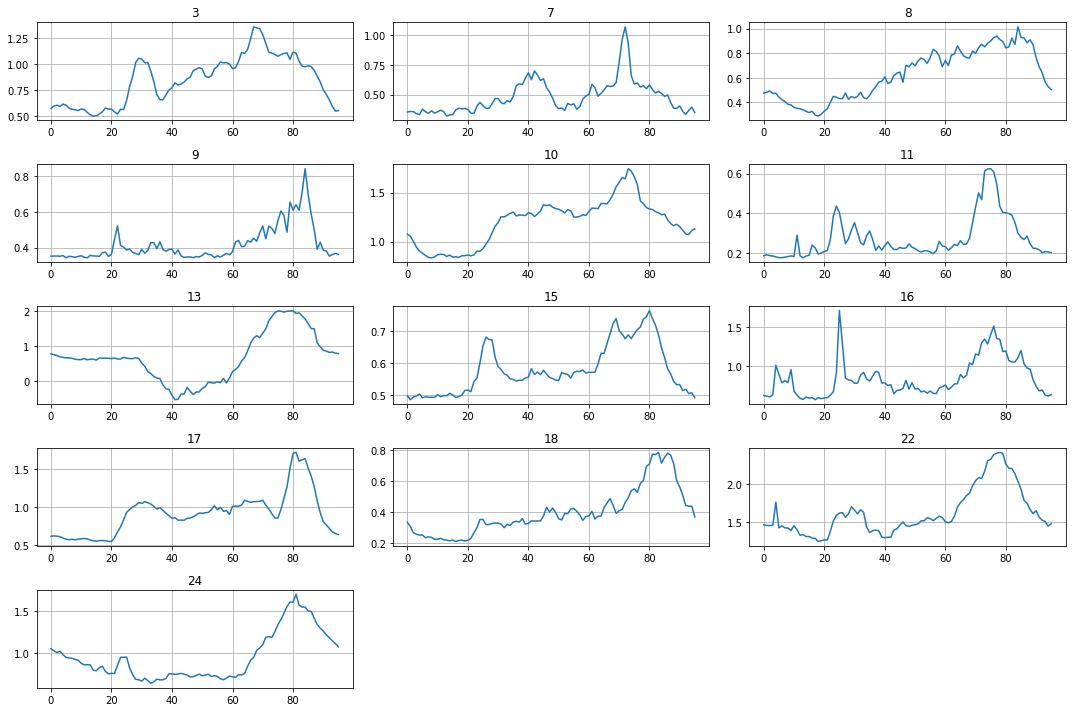

In [9]:
plt.figure(figsize=(15, 10))
for i,idx in enumerate(solar_housing_idxs):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,3,i+1) 
    plt.plot(solar_avg_house_list[i])
    plt.title(f'{idx}')
    plt.grid(True)
plt.tight_layout()

In [10]:
avg_house_pred_list= []
houseiPredict = []
houseiY = []
for i,idx in enumerate(solar_housing_idxs):
    m,s,x,y,p = get_avg_day_pred(house = idx)
    avg_house_pred_list.append(m)
    houseiY.append(y)
    houseiPredict.append(p)

In [11]:
avg_house_pred_list[0].shape

(96,)

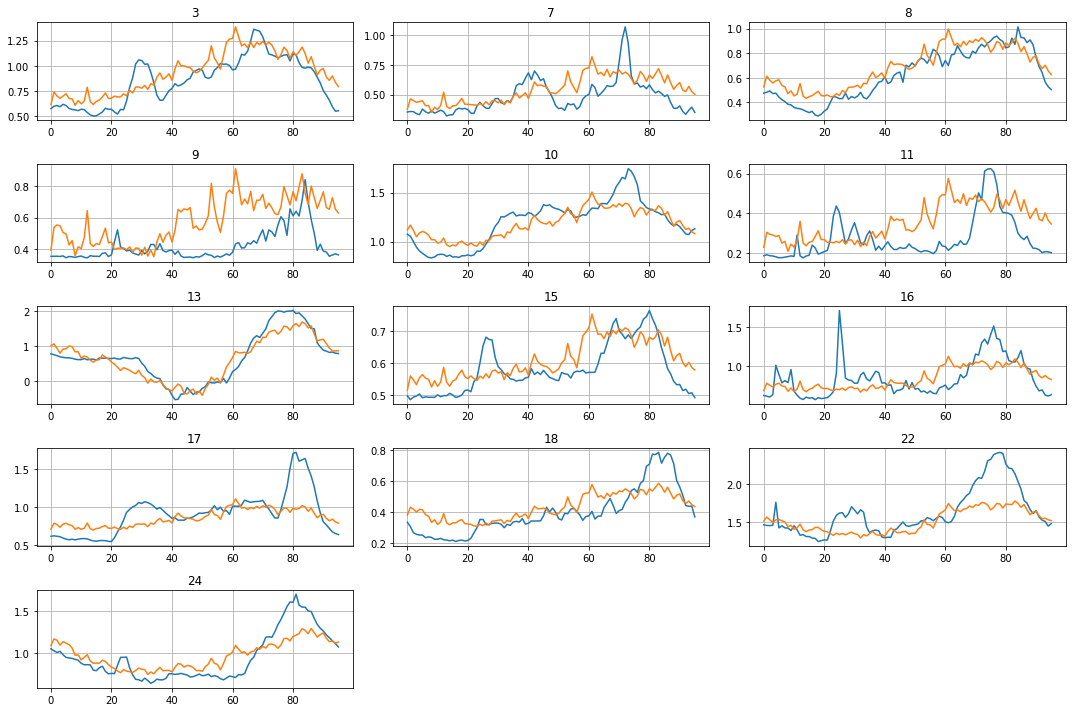

In [12]:
plt.figure(figsize=(15, 10))
for i,idx in enumerate(solar_housing_idxs):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,3,i+1) 
    plt.plot(solar_avg_house_list[i])
    plt.plot(avg_house_pred_list[i])
    plt.title(f'{idx}')
    plt.grid(True)
plt.tight_layout()
#model was trained on 3/4 so 1st 3 rows were trained on  #change to 3/4 for nonsolar
#and last rows is being tested

In [13]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 96)                24672     
Total params: 288,864
Trainable params: 288,864
Non-trainable params: 0
_________________________________________________________________


## Error of model 

In [14]:
#get error
def get_errors(avg_house_grid,pred_house_grid):
    
    error = (avg_house_grid-pred_house_grid)
    abs_error = abs(error)
    return error, abs_error

avg_house_error= []
avg_house_ab_error= []

for i,idx in enumerate(solar_housing_idxs):
#     solar_avg_house_list
#     avg_house_pred_list
    error, abs_error = get_errors(solar_avg_house_list[i], avg_house_pred_list[i])
    avg_house_error.append(error)
    avg_house_ab_error.append(abs_error)

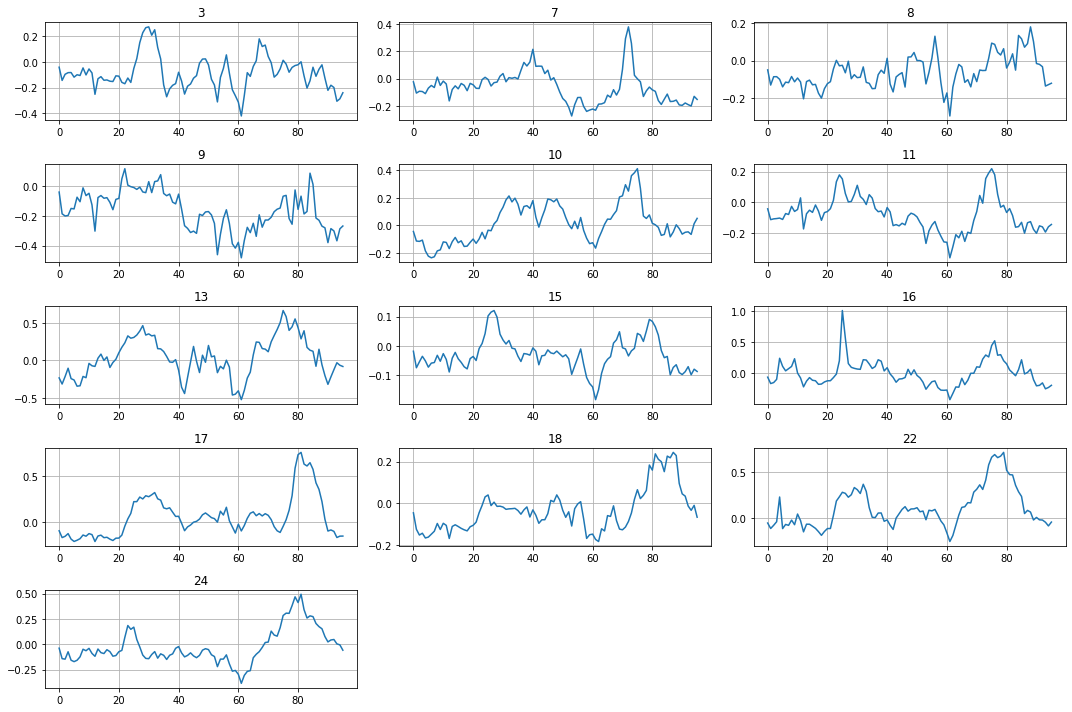

In [15]:
plt.figure(figsize=(15, 10))
for i,idx in enumerate(solar_housing_idxs):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,3,i+1) 
    plt.plot(avg_house_error[i] )
    plt.title(f'{idx}')
    plt.grid(True)
plt.tight_layout()

### Abs Error

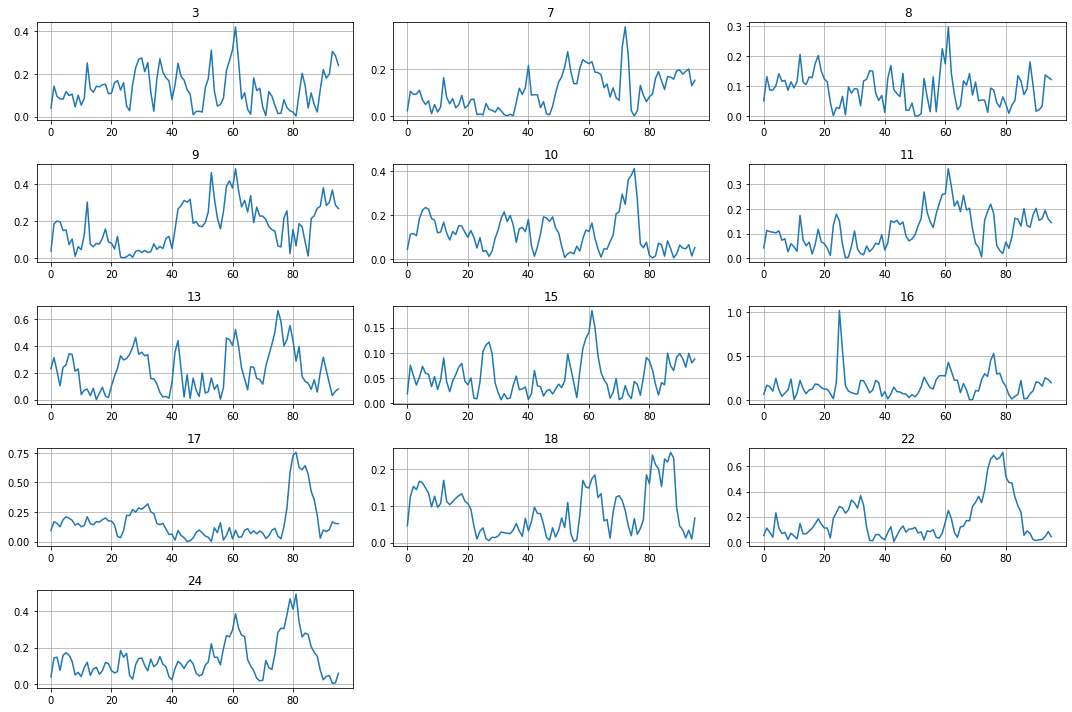

In [16]:
plt.figure(figsize=(15, 10))
for i,idx in enumerate(solar_housing_idxs):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,3,i+1) 
    
    plt.plot(avg_house_ab_error[i] )
    plt.title(f'{idx}')
    plt.grid(True)
plt.tight_layout()

In [17]:
# plt.figure(figsize=(15, 10))

max_avg  = -np.Inf
max_abs_avg  = -np.Inf
min_avg  = np.Inf
min_abs_avg  = np.Inf
# max_avg_str = 
# max_abs_avg_str = []

for i,idx in enumerate(solar_housing_idxs):

#     plt.subplot(3,4,i+1) 
    
    avg = np.mean(solar_avg_house_list[i])
    abs_avg = np.mean(avg_house_pred_list[i])
    print(f'{idx} - Mean: {avg} - Abs Mean: {abs_avg}')
    if avg > max_avg: 
        max_avg = avg 
        max_avg_str = f'{idx} - Mean: {avg} - Abs Mean: {abs_avg}'
    if abs_avg > max_abs_avg: 
        max_abs_avg = abs_avg 
        max_abs_avg_str = f'{idx} - Mean: {avg} - Abs Mean: {abs_avg}'
    if avg < min_avg: 
        min_avg = avg 
        min_avg_str = f'{idx} - Mean: {avg} - Abs Mean: {abs_avg}'
    if abs_avg < min_abs_avg: 
        min_abs_avg = abs_avg 
        min_abs_avg_str = f'{idx} - Mean: {avg} - Abs Mean: {abs_avg}'
        
print()
print(f'biggest error: {max_avg_str}')
print(f'biggest abs error: {max_abs_avg_str}')
print()
print(f'smallest error: {min_avg_str}')
print(f'smallest abs error: {min_abs_avg_str}')


3 - Mean: 0.8483794723731884 - Abs Mean: 0.9340373873710632
7 - Mean: 0.4785789175724638 - Abs Mean: 0.5411515831947327
8 - Mean: 0.6241847259963769 - Abs Mean: 0.6852156519889832
9 - Mean: 0.4173569406702898 - Abs Mean: 0.5803953409194946
10 - Mean: 1.1978215579710145 - Abs Mean: 1.1819719076156616
11 - Mean: 0.27514079483695647 - Abs Mean: 0.35548946261405945
13 - Mean: 0.6724647871376811 - Abs Mean: 0.6346054673194885
15 - Mean: 0.5802617753623186 - Abs Mean: 0.610161542892456
16 - Mean: 0.8509009850543476 - Abs Mean: 0.8465499877929688
17 - Mean: 0.9134902060688406 - Abs Mean: 0.8551591038703918
18 - Mean: 0.39657954030797105 - Abs Mean: 0.4295632839202881
22 - Mean: 1.6239174026268115 - Abs Mean: 1.514649748802185
24 - Mean: 0.9509578804347827 - Abs Mean: 0.974012553691864

biggest error: 22 - Mean: 1.6239174026268115 - Abs Mean: 1.514649748802185
biggest abs error: 22 - Mean: 1.6239174026268115 - Abs Mean: 1.514649748802185

smallest error: 11 - Mean: 0.27514079483695647 - Abs Me

### Error Percentage


In [18]:
#get std of error
errorstd_list = []
error_percentage_list = []
abs_error_percentage_list = []
for i,idx in enumerate(solar_housing_idxs):
    
    errorstd_list.append(np.std(avg_house_error[i]))
    error_percentage_list.append(errorstd_list[i]/solar_avg_house_list[i])
    abs_error_percentage_list.append(errorstd_list[i]/abs(solar_avg_house_list[i]))
#     np.mean(abs(avg_house_error[i]))



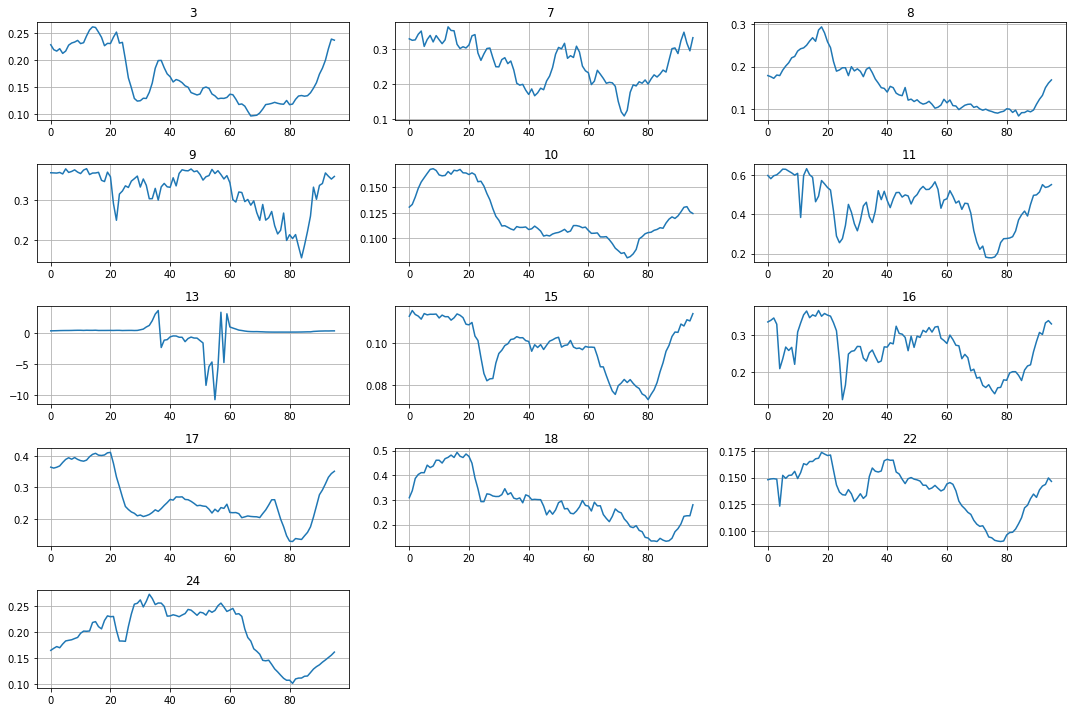

In [19]:
plt.figure(figsize=(15, 10))
for i,idx in enumerate(solar_housing_idxs):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,3,i+1) 
    
    plt.plot(error_percentage_list[i] )
    plt.title(f'{idx}')
    plt.grid(True)
plt.tight_layout()

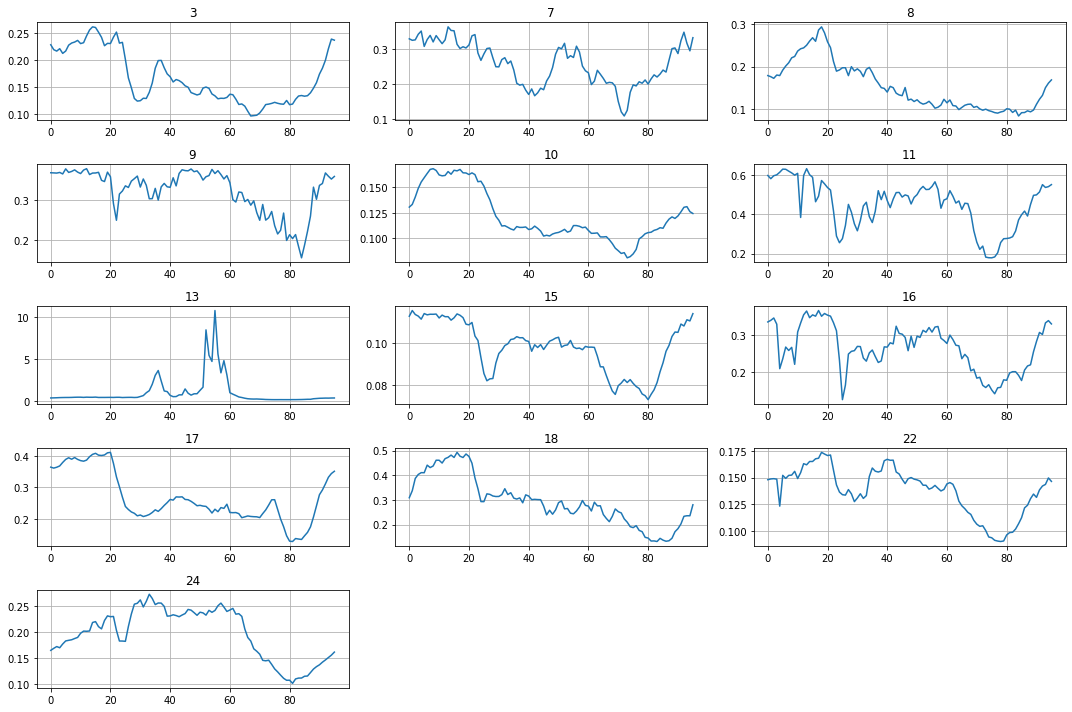

In [20]:
plt.figure(figsize=(15, 10))
for i,idx in enumerate(solar_housing_idxs):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,3,i+1) 
    
    plt.plot(abs_error_percentage_list[i] )
    plt.title(f'{idx}')
    plt.grid(True)
plt.tight_layout()

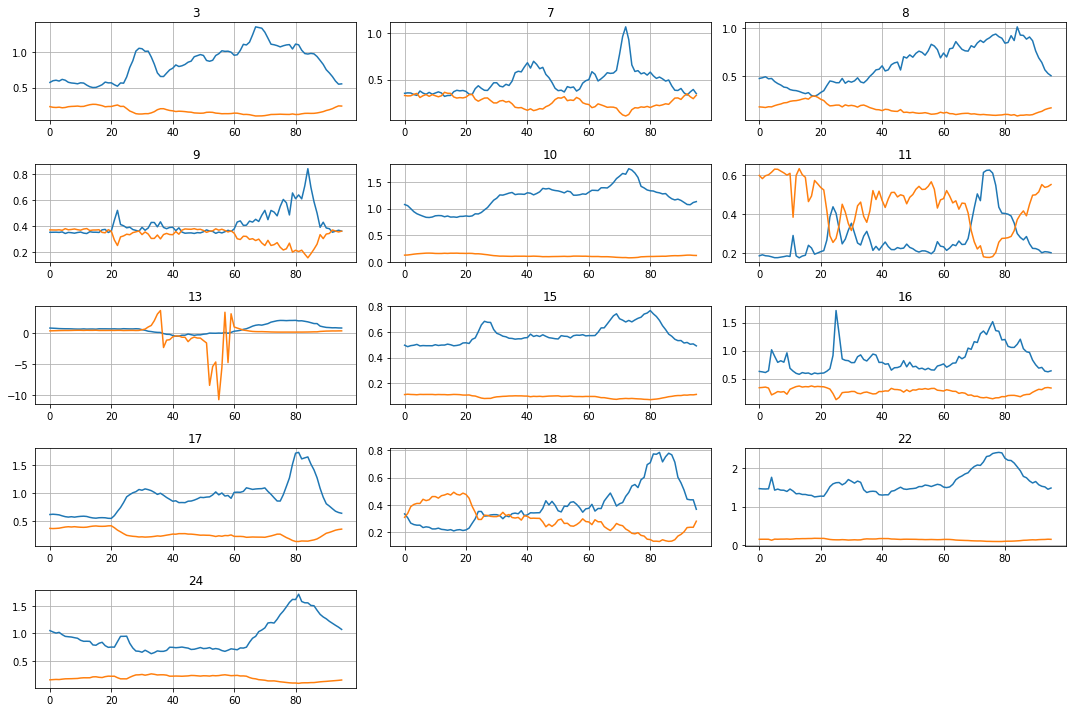

In [21]:
plt.figure(figsize=(15, 10))
for i,idx in enumerate(solar_housing_idxs):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,3,i+1) 
    plt.plot(solar_avg_house_list[i])
    plt.plot(error_percentage_list[i] )
    plt.title(f'{idx}')
    plt.grid(True)
plt.tight_layout()

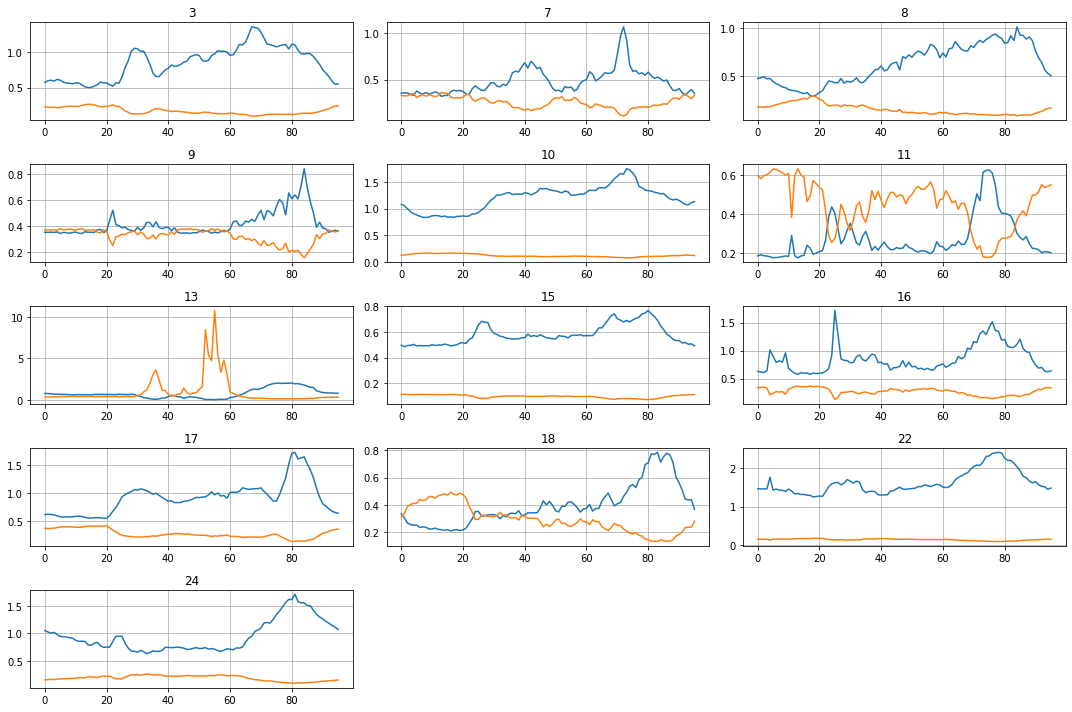

In [22]:
plt.figure(figsize=(15, 10))
for i,idx in enumerate(solar_housing_idxs):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,3,i+1) 
    plt.plot(abs(solar_avg_house_list[i]))
    plt.plot(abs_error_percentage_list[i])
    plt.title(f'{idx}')
    plt.grid(True)
plt.tight_layout()

# Distribution of error

In [23]:
# plt.figure(figsize=(15, 10))
mulist = []
varlist=[]
siglist = []
fullerrorlist = []
look_back = 96
for i,idx in enumerate(solar_housing_idxs):

    fullpredict=houseiPredict[i][::look_back].reshape(182*look_back)
    fulltrue = houseiY[i][::look_back].reshape(182*look_back)
    fullerror = fulltrue - fullpredict
    fullerrorlist.append(fullerror)
    mu = np.mean(fullerror)
    mulist.append(mu)
    variance = np.var(fullerror)
    varlist.append(variance)
    sigma = math.sqrt(variance)
    siglist.append(sigma)


/home/nathan/anaconda3/envs/ace/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nathan/anaconda3/envs/ace/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nathan/anaconda3/envs/ace/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

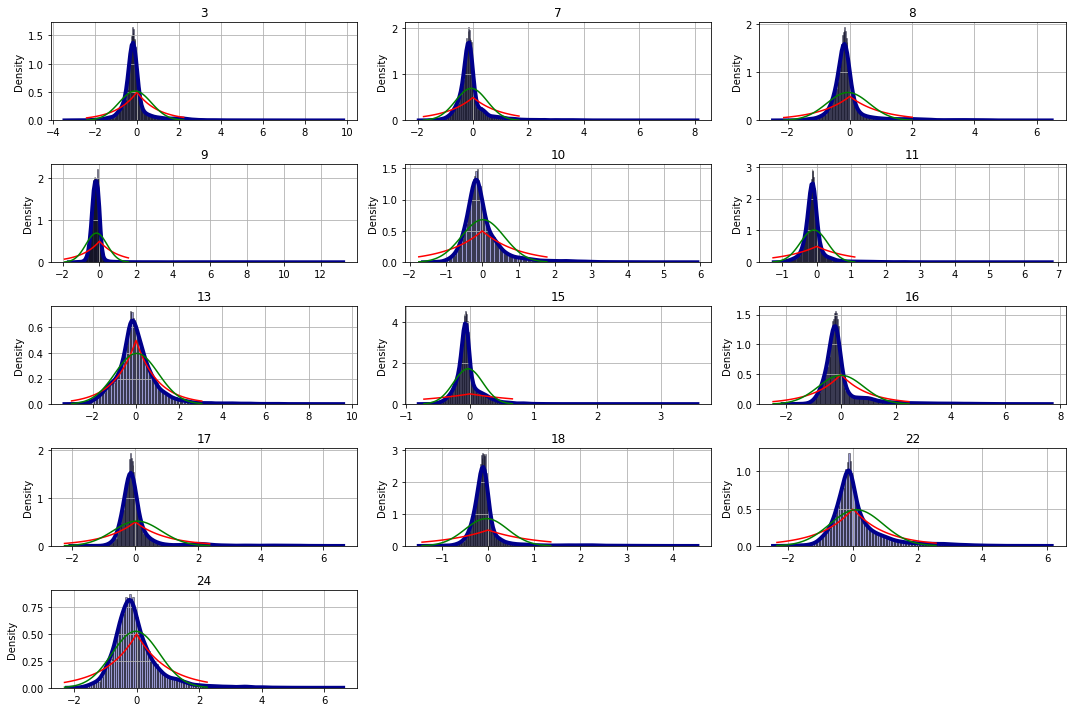

In [24]:
plt.figure(figsize=(15, 10))
for i,idx in enumerate(solar_housing_idxs):
    plt.subplot(5,3,i+1) 
    mu= mulist[i]
    sigma = siglist[i]
    fullerror = fullerrorlist[i]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    
    sns.distplot(fullerror, hist=True, kde=True, 
                 bins="auto", color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})
#     sns.displot(data=fullerror, kde=True)

    plt.plot(x, laplace.pdf(x), color ='r', label = 'laplace')
    plt.plot(x, norm.pdf(x, mu, sigma), color ='g', label = 'normal')
    plt.title(f'{idx}')
    plt.grid(True)
plt.tight_layout()